<a href="https://colab.research.google.com/github/jwang44/crispy-fiesta/blob/main/exp_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


## Load the data and get basic features

In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('./train.csv',engine='python')
test = pd.read_csv('./test.csv',engine='python')

In [4]:
X_train = train.body  # train texts
y_train = train.subreddit # train subreddits
X_test = test.body  # test texts

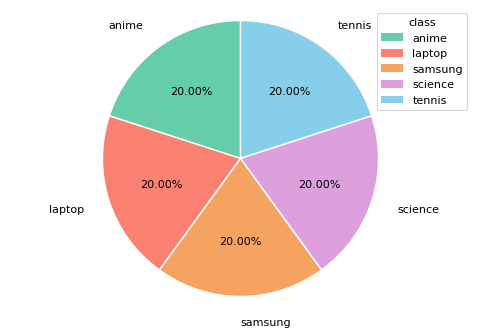

In [162]:
import matplotlib.pyplot as plt
from collections import Counter

y_labels = np.unique(y_train)

plt.figure(figsize=(7.5,5),dpi=80) # fig size
labels = list(Counter(y_labels).keys()) # label
sizes = list(Counter(y_labels).values())

colors = ['mediumaquamarine','salmon','sandybrown','plum','skyblue'] # color of each sector
explode = (0.01,0.01,0.01,0.01,0.01)
patches,text1,text2 = plt.pie(sizes,   
                      explode = explode,         
                      labels=labels,
                      colors=colors,
                      labeldistance = 1.2,
                      autopct = '%3.2f%%', 
                      shadow = False, 
                      startangle =90, 
                      pctdistance = 0.6) 
# patches: pie chart，texts1: label text，texts2: pie chart text
plt.axis('equal')
plt.legend(title = 'class')
plt.savefig('piechart.png')
plt.show()

In [5]:
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [6]:
# transform target labels to values
le = LabelEncoder()
y_train_num = le.fit_transform(y_train.values) # convert category from string to numerical (!!!!! update the variables in kcross fold)

# vectorize word count
vectorizer = CountVectorizer(binary=True)
vectors_train = vectorizer.fit_transform(X_train)
vectors_test = vectorizer.transform(X_test)

# print(vectorizer.get_feature_names())
print(vectors_train.shape)
print(vectors_test.shape)

(1999, 15365)
(1378, 15365)


In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### features:vectors_train_stop_Lemma, vectors_test_stop_Lemma

In [8]:
# put it all together: remove stop words and punctuation, lemmatization
stop_words = text.ENGLISH_STOP_WORDS

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

class New_LemmaTokenizer:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos =get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]


vectorizer = CountVectorizer(binary = True, stop_words = stop_words, tokenizer = New_LemmaTokenizer(), ngram_range=(1, 2)) #unigram+bigram:ngram_range=(1, 2), only bigram:ngram_range=(2, 2)
vectors_train_stop_Lemma = vectorizer.fit_transform(X_train)
vectors_test_stop_Lemma = vectorizer.transform(X_test)

vectorizer3000 = CountVectorizer(binary = True, max_features=3000, stop_words = stop_words, tokenizer = New_LemmaTokenizer(), ngram_range=(1, 2)) #unigram+bigram:ngram_range=(1, 2), only bigram:ngram_range=(2, 2)
vectors_train_stop_Lemma3000 = vectorizer.fit_transform(X_train)
vectors_test_stop_Lemma3000 = vectorizer.transform(X_test)

# print(vectorizer.get_feature_names())
print(vectors_train_stop_Lemma.shape)
print(vectors_test_stop_Lemma.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(1999, 70414)
(1378, 70414)


### features:vectors_train_stop_stem, vectors_test_stop_stem

In [45]:
# remove stopwords and punctuation, stemming, 
stop_words = text.ENGLISH_STOP_WORDS

class StemTokenizer:
     def __init__(self):
       self.wnl =PorterStemmer()
     def __call__(self, doc):
       return [self.wnl.stem(t) for t in word_tokenize(doc) if t.isalpha()]

vectorizer = CountVectorizer(binary = True, stop_words = stop_words, tokenizer=StemTokenizer())#, ngram_range=(1, 2)) #unigram+bigram:ngram_range=(1, 2), only bigram:ngram_range=(2, 2)
vectors_train_stop_stem = vectorizer.fit_transform(X_train)
vectors_test_stop_stem = vectorizer.transform(X_test)

vectorizer3000 = CountVectorizer(binary = True, max_features=3000, stop_words = stop_words, tokenizer=StemTokenizer())#, ngram_range=(1, 2)) #unigram+bigram:ngram_range=(1, 2), only bigram:ngram_range=(2, 2)
vectors_train_stop_stem3000 = vectorizer.fit_transform(X_train)
vectors_test_stop_stem3000 = vectorizer.transform(X_test)

print(vectors_train_stop_stem.shape)
print(vectors_test_stop_stem.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

(1999, 8522)
(1378, 8522)


## Feature selection

In [89]:
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, f_classif, mutual_info_classif, RFE, SelectFromModel

### 13.2.1 chi2  features:vectors_train_Lemma_X2, vectors_test_Lemma_X2,   
###              vectors_train_stem_X2, vectors_test_stem_X2

In [90]:
select = SelectKBest(chi2, k=3000)
vectors_train_Lemma_X2 = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_Lemma_X2 = select.transform(vectors_test_stop_Lemma)
print(vectors_train_Lemma_X2.shape)
print(vectors_test_Lemma_X2.shape)

(1999, 3000)
(1378, 3000)


In [91]:
select = SelectKBest(chi2, k=3000)
vectors_train_stem_X2 = select.fit_transform(vectors_train_stop_stem, y_train_num)
vectors_test_stem_X2 = select.transform(vectors_test_stop_stem)
print(vectors_train_stem_X2.shape)

(1999, 3000)


### 13.2.2 mutual info   features:vectors_train_Lemma_mutual vectors_test_Lemma_mutual,   
###vectors_train_stem_mutual, vectors_test_stem_mutual

In [92]:
select = SelectKBest(mutual_info_classif, k=3000)
vectors_train_Lemma_mutual = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_Lemma_mutual = select.transform(vectors_test_stop_Lemma)
print(vectors_train_Lemma_mutual.shape)

(1999, 3000)


In [93]:
select = SelectKBest(mutual_info_classif, k=3000)
vectors_train_stem_mutual = select.fit_transform(vectors_train_stop_stem, y_train_num)
vectors_test_stem_mutual = select.transform(vectors_test_stop_stem)
print(vectors_train_stem_mutual.shape)

(1999, 3000)


### 13.2.3 F score  features:vectors_train_Lemma_F, vectors_test_Lemma_F,   
###vectors_train_stem_F, vectors_test_stem_F

In [94]:
select = SelectKBest(f_classif, k=3000)
vectors_train_Lemma_F = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_Lemma_F = select.transform(vectors_test_stop_Lemma)
print(vectors_train_Lemma_F.shape)

(1999, 3000)


In [95]:
select = SelectKBest(f_classif, k=3000)
vectors_train_stem_F = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_stem_F = select.transform(vectors_test_stop_Lemma)
print(vectors_train_stem_F.shape)

(1999, 3000)


### 13.3 Recursive feature elimination features:vectors_train_Lemma_RFE, vectors_test_Lemma_RFE,   
###vectors_train_stem_RFE, vectors_test_stem_RFE

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import KFold, cross_val_score

In [97]:
estimator = BernoulliNB()
select = RFE(estimator, n_features_to_select=3000, step=0.1)
vectors_train_Lemma_RFE = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_Lemma_RFE = select.transform(vectors_test_stop_Lemma)
print(vectors_train_Lemma_RFE.shape)

(1999, 3000)


In [98]:
estimator = BernoulliNB()
select = RFE(estimator, n_features_to_select=3000, step=0.1)
vectors_train_stem_RFE = select.fit_transform(vectors_train_stop_stem, y_train_num)
vectors_test_stem_RFE = select.transform(vectors_test_stop_stem)

### 13.4 selectfrommodel

In [99]:
estimator = LinearSVC(C=0.01, penalty="l1",dual=False)
select = SelectFromModel(estimator,max_features=3000)
vectors_train_Lemma_SFM = select.fit_transform(vectors_train_stop_Lemma, y_train_num)
vectors_test_Lemma_SFM = select.transform(vectors_test_stop_Lemma)
print(vectors_train_Lemma_SFM.shape)

(1999, 25)


In [100]:
estimator = LinearSVC(C=0.01, penalty="l1",dual=False)
select = SelectFromModel(estimator,max_features=3000)
vectors_train_stem_SFM = select.fit_transform(vectors_train_stop_stem, y_train_num)
vectors_test_stem_SFM = select.transform(vectors_test_stop_stem)
print(vectors_train_stem_SFM.shape)

(1999, 29)


## Bernoulli NB model

In [22]:
import time
import random

In [23]:
class Bernoulli_NB():
  def __init__(self, LaplaceSmoothing = True):
    self.LaplaceSmoothing = LaplaceSmoothing
    self.Prob_Y = None      # P(Y)
    self.Prob_X_Y = None     # P(xj|Y)
    self.Prob_X_Y = None     # P(xj|Y)
    self.n_class = 0
    self.w0 = None
    self.w = None
    self.Ytarget = None

  def ProbY(self, Y):
    # calculate P(Y=1) and P(Y=0)
    ProbY = np.zeros((1,2))
    ProbY[0,1] = np.sum(Y)/np.shape(Y)
    ProbY[0,0] = 1 - ProbY[0,1]
    return ProbY

  def ProbX_Yi(self, X, Y, label):
    # calculte P(xj=1|Yi=1)
    rows,cols = X.shape       # feature shape
    numerator = np.zeros((1,cols))    # initialize numerator

    # xj=1 and Yi=1
    for n in range(rows):
      if Y[n] == label:
        numerator += X[n,:]
    # Yi=1
    denominator = np.count_nonzero(Y == label)

    # Laplace Smoothing

    if(self.LaplaceSmoothing):
      numerator += 1
      denominator += 2

    # P(xj=1|Yi=1)
    prob = numerator/denominator
    return prob    

  def fit(self, X, Y):
    #print('---------------------- start fitting ---------------------')
    t1 = time.time()
    
    rows,cols = X.shape              # feature shape
    self.n_class = len(np.unique(Y))       # number of classes
    self.Prob_Y = np.zeros((self.n_class,2))   # initialize P(Y)
    self.Prob_X_Y = np.zeros((self.n_class,2,cols)) # initialize P(x|Y)
    c = np.zeros((self.n_class,cols))       # rows:class cols:xj
    d = np.zeros((self.n_class,cols))       # rows:class cols:xj
    self.w0 = np.zeros((1,self.n_class))     # [w0Y1,w0Y2,...]
    self.w = np.zeros((self.n_class,cols))    # [(w1,w2,...)Y1;
                            # (w1,w2,...)Y2]
    for Yi in range(self.n_class):
      Y_onevsall = np.where(Y == Yi, 1, 0)    # only have 2 classes: Yi(1) & notYi(0)
      #print(np.unique(Y_onevsall))
      self.Prob_Y[Yi,:] = self.ProbY(Y_onevsall)   # [P(notYi), P(Yi)]
      self.Prob_X_Y[Yi,0,:] = self.ProbX_Yi(X,Y_onevsall,0)  # [P(x1|notYi), P(x2|notYi),...]
      self.Prob_X_Y[Yi,1,:] = self.ProbX_Yi(X,Y_onevsall,1)  # [P(x1|Yi), P(x2|Yi),...]
      
      #print(np.where(self.Prob_Y[Yi,1] == 0))
      c[Yi,:] = np.log10(self.Prob_X_Y[Yi,1,:]/self.Prob_X_Y[Yi,0,:])     # log(P(xj|Y=1)/P(xj|Y=0))
      d[Yi,:] = np.log10((1-self.Prob_X_Y[Yi,1,:])/(1-self.Prob_X_Y[Yi,0,:])) # log((1-P(xj|Y=1))/(1-P(xj|Y=0)))
      self.w0[0,Yi] = np.log10(self.Prob_Y[Yi,1]/self.Prob_Y[Yi,0]) + np.sum(d[Yi,:])
      self.w[Yi,:] = c[Yi,:] - d[Yi,:]

    #print('------ fit done, total time: ',time.time()-t1,' -----')
    # return self.Prob_Y,self.Prob_X_Y

  def predict(self, X):
    #print('---------------------- start predict ---------------------')
    t1 = time.time()
    
    #X = self.encoder(X)
    rows,cols = np.shape(X)       # feature shape
    PreY = np.zeros(rows) # initialize Y
    # print('type',type(PreY),'pre',PreY)
    LogOddsRatio = np.zeros((1,self.n_class))  # initialize log odds ratio a(x) 
    Logistic = np.zeros((1,self.n_class))    # initialize logistic function
    Y_index = 0
    for obs in range(rows):
      for Yi in range(self.n_class): 
        #print(self.w[Yi,:].shape)
        part2 = self.w[Yi,:].reshape(1,cols) @ np.transpose(X[obs,:])
        LogOddsRatio[0,Yi] = self.w0[0,Yi] + part2.astype(np.float64)
        Logistic[0,Yi] = 1/(1+np.exp(-LogOddsRatio[0,Yi]))

      pre = np.where(Logistic == np.amax(Logistic))[1]    # find max logistic (type:numpy.ndarray)
      # random pick one if have multiple max logistic
      if pre.shape[0] > 1:
        PreY[obs] = random.choice(pre)
      else:
        PreY[obs] = pre
    #print('------ predict done, total time: ',time.time()-t1,' -----')
    return PreY

  def score(self,X,Y):
    # Return the mean accuracy on the given test data and labels.
    PreY = self.predict(X)
    rows = np.shape(Y)[0]
    n_correct = 0;
    for obs in range(rows):
      if PreY[obs] == Y[obs]:
        n_correct += 1
    #print('n:',n_correct)
    #print('rows:',rows)
    accuracy = n_correct / rows
    #print('------------------ accuracy:',accuracy,' -----------------')
    return accuracy


## Experiment with Bernoulli Model

In [24]:
from sklearn.model_selection import KFold
import statistics
kf = KFold(n_splits=10, shuffle=True)
model = Bernoulli_NB()

In [25]:
def k_cross_val_score(X, y):
  score = []
  for train_index, test_index in kf.split(X):
    kX_train, kX_test = X[train_index], X[test_index]
    ky_train, ky_test = y[train_index], y[test_index]
    model.fit(kX_train, ky_train)
    score.append(model.score(kX_test, ky_test))
    #print("test accu: ", model.score(X_test, y_test))
  return score

In [73]:
scores = k_cross_val_score(vectors_train_stop_stem, y_train_num)
print(statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stop_Lemma, y_train_num)
print(statistics.mean(scores))

0.8949673366834171
0.7503743718592965


In [74]:
scores = k_cross_val_score(vectors_train_stop_stem3000, y_train_num)
print('vectors_train_stop_stem3000',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stop_Lemma3000, y_train_num)
print('vectors_train_stop_Lemma3000',statistics.mean(scores))

vectors_train_stop_stem3000 0.888467336683417
vectors_train_stop_Lemma3000 0.7513492462311557


In [103]:
scores = k_cross_val_score(vectors_train_Lemma_X2, y_train_num)
print('vectors_train_Lemma_X2',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stem_X2, y_train_num)
print('vectors_train_stem_X2',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_Lemma_mutual, y_train_num)
print('vectors_train_Lemma_mutual',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stem_mutual, y_train_num)
print('vectors_train_stem_mutual',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_Lemma_F, y_train_num)
print('vectors_train_Lemma_F',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stem_F, y_train_num)
print('vectors_train_stem_F',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_Lemma_RFE, y_train_num)
print('vectors_train_Lemma_RFE',statistics.mean(scores))

scores = k_cross_val_score(vectors_train_stem_RFE, y_train_num)
print('vectors_train_stem_RFE',statistics.mean(scores))

vectors_train_Lemma_X2 0.8554246231155779
vectors_train_stem_X2 0.9259698492462312
vectors_train_Lemma_mutual 0.8554346733668342
vectors_train_stem_mutual 0.9279698492462312
vectors_train_Lemma_F 0.8594371859296482
vectors_train_stem_F 0.853929648241206
vectors_train_Lemma_RFE 0.17709045226130654
vectors_train_stem_RFE 0.17207035175879398


## Write results to CSV

In [113]:
model = Bernoulli_NB()
model.fit(vectors_train_stem_mutual,y_train_num)
scores = k_cross_val_score(vectors_train_stem_mutual, y_train_num)
print(statistics.mean(scores))

0.9264623115577889


In [114]:
y_pred = model.predict(vectors_test_stem_mutual)
y_pred = y_pred.astype(int)
y_pred = le.inverse_transform(y_pred)

In [118]:
result = pd.DataFrame({'id': test.id, 'subreddit': y_pred})
result.to_csv("resultmutual.csv", index=False)

In [119]:
pred_csv = pd.read_csv('resultmutual.csv',engine='python')
pred_csv.head()

,id,subreddit
0,0,science
1,1,tennis
2,2,laptop
3,3,science
4,4,science
